In [1]:
import cv2
#keep in mind that cv2 uses BGR representation, while PIL and matplotlib uses RGB
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    #frame = cv2.resize(frame, None, fx = 0.5, fy = 0.5, interpolation = cv2.INTER_AREA)
    frame = cv2.resize(frame, (416,416), interpolation = cv2.INTER_AREA)
    cv2.imshow('INPUT', frame)
    
    key = cv2.waitKey(1)
    if key == 27:
        break
print(frame.shape)
cap.release()
cv2.destroyAllWindows()

(416, 416, 3)


In [1]:
#The following code is from andrew Ng
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body
import imageio

%matplotlib inline

C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1)

In [2]:
#read classes for the YOLO
def read_classes(path):
    classList = []
    with open(path) as file:
        classType = file.readline().strip()
        while classType:
            classList.append(classType)
            classType = file.readline().strip()
    return classList

#read the available anchor boxes for the yolo
def read_anchors(path):
    with open(path) as file:
        anchors = file.readline().strip()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

In [3]:
#make the function to select the output:
def yolo_score_selection(box_confidence, boxes, box_class_probs, threshold = 0.6):
    """This function will throw the score (box_confidence * box_class_probs) that is less than the threshold.
    
    (since this model uses 19x19x5x85 size, all box_confidence, boxes, box_class_probs will assume similar format)
    
    5 anchor boxes is used here
    
    Arguments:
    box_confidence = keras tensor in shape of (19x19x5x1), indicating Pc of entire boxes
    boxes = keras tensor in shape of (19x19x5x4) indicating the bounding boxes coordinate (either topleft-bottomright, or bx,by,bh,bw)
    box_class_probs = keras tensor in shape of (19x19x5x80) indicating which class is detected in each anchor box
    
    return:
    scores = the tensor of scores that passes the threshold, in shape of (None, )
    boxes = the tensor of boxes that passes the threshold, in shape of (None, 4)
    classes = the tensor of classes that passes the threshold, in shape of (None,), has been converted with argmax
    *the None will be the number of boxes that passes the thrreshold score test"""  
    
    AllScores = box_confidence * box_class_probs
    scores = K.max(AllScores,axis = -1)
    classes = K.argmax(AllScores,axis = -1)
    mask = scores >= threshold
    
    scores = tf.boolean_mask(scores, mask)
    boxes = tf.boolean_mask(boxes,mask)
    classes = tf.boolean_mask(classes,mask)
    
    return scores,boxes,classes

In [4]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_score_selection(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
scores[2] = 10.750582
boxes[2] = [ 8.426533   3.2713668 -0.5313436 -4.9413733]
classes[2] = 7
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


In [5]:
#assuming that we don't need to implement our own Iou anymore, now we need to make our own non_max_suppression
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """Applies the non max suppresion algorithm to:
    1. Select the box with the highest score
    2. Compute the IoU of this box with the others, if (iou >= iou_threshold), remove the box
    3. Go back to step 1 until there are no longer lower score boxes
    
    *non_max_suppression will use tf.image.non_max_suppression(boxes, scores, max_output_size, iou_threshold = 0.5, name = None) and 
    keras.gather(reference, indices)
    
    Arguments:
    scores = tensor in shape of (None,), output of yolo_filter_boxes
    boxes = tensor in shape of (None,4), output of yolo_filter_boxes
    classes = tensor in shape of (None,), output of yolo_filter_boxes
    max_boxes = integer, maximum number of predicted boxes in one image that is preffered
    iou_threshold = real, IOU threshold for non max suppresion filtering
    
    Returns:
    scores = tensor of shape (,None), predicted score for eeach box
    boxes = tensor of shape (4,None), predicted box coordinates
    classes = tensor of shape (,None), predicted class for each box
    
    *None must be lower than the max_boxes. Output is transposed dimension of the input for convenience (as a result of keras.gather)."""
    #convert the max_boxes to max_boxes_tensor
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))#intialize variable
    
    #for the boundinng boxes, we supplied with [y1,x1,y2,x2], where 1 and 2 indicates the top-left and bottom-right, can be absolute or normalized(0-1)
    
    indices = tf.image.non_max_suppression(boxes, scores, max_output_size = max_boxes_tensor, iou_threshold = iou_threshold) #score threshold doesn't exist in older tensorflow
    
    #use the returned indices of the chosen boxes for the K.gather
    
    scores = K.gather(scores, indices)
    boxes = K.gather(boxes, indices)
    classes = K.gather(classes, indices)
    
    return scores,boxes, classes

In [6]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 6.938395
boxes[2] = [-5.299932    3.1379814   4.450367    0.95942086]
classes[2] = -2.2452729
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [7]:
def XYWHToTopLeftBottomRight(box_xy,box_wh):
    """Convert tensor of input (box_xy,box_wh) to the [top-left,bottom-right] coordinate
    
    Arguments:
    box_xy = tensor of shape(None, 19,19, 5,2) of the midpoint
    box_wh = tensor of shape(None, 19,19,5,2) of the width height respective midpoint
    
    Returns:
    boxes_corners = (None, 19,19, 5, 4) shaped tensor. 
    The last axis in shape of (y1,x1,y2,x2) point where the y1,x1 = top-left coordinate, y2,x2 = bottom right coordinate"""
    
    topLeftPoint = box_xy - (box_wh/2.0)
    bottomRightPoint = box_xy + (box_wh/2.0)
    #note that at this point, everything is still in xy, we need it to be yx for the non_max_suppression
    return K.concatenate([topLeftPoint[...,1:2], topLeftPoint[...,0:1], bottomRightPoint[...,1:2], bottomRightPoint[...,0:1]])

In [8]:
def scale_boxes(boxes, image_shape):
    """Scale the predicted boxes from the normalized value (0-1) of the whole image, to its respective original shape
    
    arguments:
    boxes= tensor in shape of (None, 19, 19, 5, 4), where last axis in shape of (y1,x1,y2,x2)
    image_shape = numpy array of the original image shape, (height, width)
    
    returns:
    boxes = tensor that has been rescaled based on the value of original image shape"""
    
    height  = image_shape[0]
    width = image_shape[1]
    multiplier = K.stack([height,width,height,width])
    multiplier = K.reshape(multiplier, shape = [1,4])
    boxes = boxes * multiplier
    return boxes

In [9]:
#gather the yolo_score_selection and yolo_non_max_suppression in this function
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes = 10, score_threshold = .6, iou_threshold = .5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    
    *Yolov2 default model take input shape of 608x608, different size of image will be resized, hence the output boxes should also be resized.
    """
    print(image_shape)
    
    #Note: box_xy and box_wh from this operation will have the valuue between 0 - 1, since it is normalized
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    
    #keep in mind in the yolo_non_max_suppression, the tf.image.non_max_suppression should use the box convention of [top-left,bottom-right], so we need to convert it first
    boxes_corners = XYWHToTopLeftBottomRight(box_xy,box_wh)
    #up till this point, boxes_corners value will still be between 0 and 1, since it is normalized
    
    #filter based on score first
    scores, boxes,classes = yolo_score_selection(box_confidence, boxes_corners, box_class_probs, threshold = score_threshold)
    
    #before filtering with the iou, make sure that we rescale the box with the correct dimension first, to get the correct IoU
    boxes=scale_boxes(boxes, image_shape)
    
    #do non_max_suppresion
    scores,boxes,classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    return scores,boxes,classes

In [10]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

(720.0, 1280.0)
scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


In [11]:
#Generate the colors for each class
from keras import backend as K
import colorsys
import random
def generate_color(classList):
    """From the number of available class, generate random colors that will be used for the classes
    
    Arguments:
    classList = the list of the class used for the yolo
    
    Output:
    rgb_tuples = create tuple of generated rgb colors"""
    hsv_tuples = [(x/len(classList),1,1) for x in range(len(classList))]
    rgb_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    #everything from colorsys will be between 0 and 1, scale it back to 255
    rgb_tuples = list(map(lambda x: (int(x[0]*255), int(x[1]*255), int(x[2]*255)),rgb_tuples))
    random.seed(10101) #just a seed so we have consistent output
    random.shuffle(rgb_tuples)
    random.seed(None)
    return rgb_tuples
#preprocess an image to the respective size for yolo input
import imghdr #to use with what for return the image_type
from PIL import Image
import numpy as np
def preprocess_image(imagePath, imageSize):
    """Preprocesss the image to resize it with the desired size and normalize it with /255.
    
    arguments:
    imagePath = the path of the image to be processed
    imageSize = the desired dimension of the image in terms of height x width
    
    returns:
    img = image file opened in python, unresized and unnormalized
    imgData = the numpy array of the image in python, resized and normalized"""
    image_type = imghdr.what(imagePath)
    img = Image.open(imagePath)
    resizedImg = img.resize(tuple(imageSize), Image.BICUBIC)
    imgData = np.array(resizedImg, dtype = 'float32')
    imgData /= 255.
    imgData = np.expand_dims(imgData,0) #dimension will be expanded on axis 0 to add batch dimennsion
    
    return img, imgData
#draw the bounding boxes on the image file
from PIL import ImageDraw, ImageFont

def drawBoxes(image,out_scores, out_boxes, out_classes, class_names, colors):
    """Draw the square around the predicted object and writing the predicted class
    
    Arguments:
    image = the image that is loaded from the Image.imread() in te preprocess function
    out_scores = the predicted scores in an image, in shape of [None, ]
    out_boxes = the predicted box coordinates in an image, in shape of [None, 4]. Using corner convention.
    out_classes = the predicted classes in an image, in shape of [None, ]. The elements are already in number.
    class_names = the list of all the yolo's class names.
    colors = the list of RGB color tuples for each color classes
    
    The None here indicates the number of the object detected inside a picture. 
    
    Returns:
    drawnImage = the image that has been written with the text and the box
    """
    
    #setting the font for the ImageDraw
    font = ImageFont.truetype(font = "font/FiraMono-Medium.otf", size = np.floor(3e-2 * image.size[1] +  0.5).astype('int32'))
    #setting the thickness of the drawnbox
    thickness = (image.size[0] + image.size[1]) // 300
    
    for i,c in enumerate(out_classes):
        #the i will be the number of iteration, c will be the item inside out_classes, which is the number of predicted class
        current_class = class_names[c]
        current_score = out_scores[i]
        current_boxes = out_boxes[i]
        
        label = "{} {:.2f}".format(current_class, current_score)
        
        draw = ImageDraw.Draw(image) #save the instance to draw, note that it will directly modify the Image in place
        label_size = draw.textsize(label,font) #also save this instance for future writing of the function
        #label_size is in the form of width x height due to the getsize function
        
        #make the coordinate to note where to draw the box and the text
        y1,x1,y2,x2 = current_boxes
        y1 = max(0, np.floor(y1+0.5).astype('int32')) #to make sure that the y1 is valid, that is >=0
        x1 = max(0, np.floor(x1+0.5).astype('int32')) #to make sure that the x1 is valid, that is >=0
        y2 = min(image.size[0], np.floor(y2+0.5).astype('int32')) #to make sure the y2 is valid, <= height
        x2 = min(image.size[1], np.floor(x2+0.5).astype('int32')) #to make sure the y2 is valid, <= width
        
        #placing the text origin of the label. Keep in mind that it will use (x,y) convention because
        #PIL uses x_y coordinate
        if(y1-label_size[1] >= 0):
            text_origin = np.array([x1,y1-label_size[1]])
        else:
            text_origin = np.array([x1,y1+1]) #added by 1 so it wouldn't really fit too much to the top
        #text origin will serve as the top left coordinate of the text
        #beginning drawing the image
        draw.rectangle([(x1,y1),(x2,y2)], outline = colors[c], width = thickness)
        
        #make the label rectangle
        draw.rectangle([tuple(text_origin), tuple(text_origin+label_size)], fill = colors[c])
        draw.text(text_origin, label, fill = (0,0,0), font = font)
        
        #free the current draw variable
        del draw
        
def drawBoxesDirectly(image,out_scores, out_boxes, out_classes, class_names, colors):
    """Draw the square around the predicted object and writing the predicted class
    
    Arguments:
    image = the image that is loaded from the cv2.imread() in te preprocess function
    out_scores = the predicted scores in an image, in shape of [None, ]
    out_boxes = the predicted box coordinates in an image, in shape of [None, 4]. Using corner convention.
    out_classes = the predicted classes in an image, in shape of [None, ]. The elements are already in number.
    class_names = the list of all the yolo's class names.
    colors = the list of RGB color tuples for each color classes
    
    The None here indicates the number of the object detected inside a picture. 
    
    Returns:
    drawnImage = the image that has been written with the text and the box
    """
    
    #setting the font for the ImageDraw
    font = ImageFont.truetype(font = "font/FiraMono-Medium.otf", size = np.floor(3e-2 * image.shape[1] +  0.5).astype('int32'))
    #setting the thickness of the drawnbox
    thickness = (image.shape[0] + image.shape[1]) // 300
    
    for i,c in enumerate(out_classes):
        #the i will be the number of iteration, c will be the item inside out_classes, which is the number of predicted class
        current_class = class_names[c]
        current_score = out_scores[i]
        current_boxes = out_boxes[i]
        
        label = "{} {:.2f}".format(current_class, current_score)
        
        draw = ImageDraw.Draw(image) #save the instance to draw, note that it will directly modify the Image in place
        label_size = draw.textsize(label,font) #also save this instance for future writing of the function
        #label_size is in the form of width x height due to the getsize function
        
        #make the coordinate to note where to draw the box and the text
        y1,x1,y2,x2 = current_boxes
        y1 = max(0, np.floor(y1+0.5).astype('int32')) #to make sure that the y1 is valid, that is >=0
        x1 = max(0, np.floor(x1+0.5).astype('int32')) #to make sure that the x1 is valid, that is >=0
        y2 = min(image.shape[0], np.floor(y2+0.5).astype('int32')) #to make sure the y2 is valid, <= height
        x2 = min(image.shape[1], np.floor(x2+0.5).astype('int32')) #to make sure the y2 is valid, <= width
        
        #placing the text origin of the label. Keep in mind that it will use (x,y) convention because
        #PIL uses x_y coordinate
        if(y1-label_size[1] >= 0):
            text_origin = np.array([x1,y1-label_size[1]])
        else:
            text_origin = np.array([x1,y1+1]) #added by 1 so it wouldn't really fit too much to the top
        #text origin will serve as the top left coordinate of the text
        #beginning drawing the image
        draw.rectangle([(x1,y1),(x2,y2)], outline = colors[c], width = thickness)
        
        #make the label rectangle
        draw.rectangle([tuple(text_origin), tuple(text_origin+label_size)], fill = colors[c])
        draw.text(text_origin, label, fill = (0,0,0), font = font)
        
        #free the current draw variable
        del draw

In [12]:
#defining the class names and anchors
sess = K.get_session()
class_names = read_classes("model_data/coco_classes.txt")
#anchors = read_anchors("model_data/yolo_anchors.txt")
anchors = read_anchors("model_data/yolov2-tiny_anchors.txt")
print(anchors)
image_shape = (480., 640.)
#image_shape = (720.,1280.)

[[0.57273  0.677385]
 [1.87446  2.06253 ]
 [3.33843  5.47434 ]
 [7.88282  3.52778 ]
 [9.77052  9.16828 ]]


In [13]:
#yolo_model = load_model("model_data/yolo.h5")
yolo_model = load_model("model_data/yolov2-tiny.h5")

C:\Users\Hp\anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [14]:
yolo_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 416, 416, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 416, 416, 16)      432       
_________________________________________________________________
batch_normalization_1 (Batch (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 416, 416, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 208, 208, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 208, 32)      4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 208, 208, 32)      128 

In [15]:
print(anchors)

[[0.57273  0.677385]
 [1.87446  2.06253 ]
 [3.33843  5.47434 ]
 [7.88282  3.52778 ]
 [9.77052  9.16828 ]]


In [16]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names)) #convert output of the model to usable bounding box tensors
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape) #filtering and choosing the best boxes

(480.0, 640.0)


In [17]:
#make the predict function as a function to gather every previous function

def predict(sess, imagePath):
    """Arrange everything inside this function.
    
    Arguments:
    sess = the previous K.get_session() that contains the model
    imagePath = the file path of the image, not included with the 'images/' folder directory
    
    Returns:
    output_image = PIL.Image.open() of the result image including the added scores, boxes and classes
    out_scores = tensor shape (None, ), scores of the predicted boxes
    out_boxes = tensor of shape(None, 4), coordinates of the predicted boxes
    out_classes = tensor of shape (None, ), class index of thee predicted boxes
    
    
    None = amount of the predicted boxes, ranging from 0 - max_boxes
    by default, max_boxes will be set to 10 in this function"""
    
    readPath = "images/"+imagePath
    #preprocess the image first, return the copy of the same image and the data of the image
    img, imgData = preprocess_image(readPath, (416,416))
    
    #run the session to get the scores, boxes, and classes
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict= {yolo_model.input : imgData, K.learning_phase():0})
    #create the list of color needed for the classes
    colors = generate_color(class_names)
    
    #draw the boxes based on the generated colors
    drawBoxes(img,out_scores, out_boxes, out_classes, class_names, colors)
    
    #save the image on the output folder
    img.save(os.path.join("out", imagePath), quality=90)
    
    output_image = Image.open(os.path.join("out", imagePath))
    imshow(output_image)
    
    #optional, return the image
    return output_image, out_scores, out_boxes, out_classes

YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!
YES!


KeyboardInterrupt: 

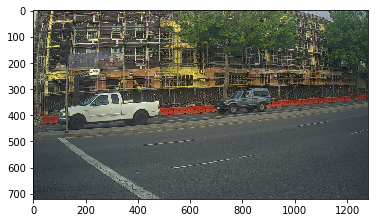

In [19]:
import os

for i in os.listdir("images/"):
    output_image,out_scores,out_boxes,out_classes = predict(sess, i)
    if(len(out_scores) != 0):
        print("YES!")

In [18]:
colors = generate_color(class_names)
def predictDirectly(sess, image,colors):
    """Arrange everything inside this function.
    
    Arguments:
    sess = the previous K.get_session() that contains the model
    imagePath = the file path of the image, not included with the 'images/' folder directory
    
    Returns:
    output_image = PIL.Image.open() of the result image including the added scores, boxes and classes
    out_scores = tensor shape (None, ), scores of the predicted boxes
    out_boxes = tensor of shape(None, 4), coordinates of the predicted boxes
    out_classes = tensor of shape (None, ), class index of thee predicted boxes
    
    
    None = amount of the predicted boxes, ranging from 0 - max_boxes
    by default, max_boxes will be set to 10 in this function"""
    imgData = np.array(image, dtype = 'float32')
    imgData /= 255.
    imgData = np.expand_dims(imgData,0)
    
    #run the session to get the scores, boxes, and classes
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict= {yolo_model.input : imgData, K.learning_phase():0})
    #create the list of color needed for the classes
    
    #draw the boxes based on the generated colors
    drawBoxes(image,out_scores, out_boxes, out_classes, class_names, colors)
    
    
    #optional, return the image
    return image, out_scores, out_boxes, out_classes

In [19]:
import cv2
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    frame = cv2.resize(frame, (416,416), interpolation = cv2.INTER_AREA)
    im_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    im_rgb = Image.fromarray(im_rgb)
    output_image, out_scores, out_boxes, out_classes = predictDirectly(sess, im_rgb,colors)
    output_image = np.asarray(output_image)
    output_image = cv2.resize(output_image, (480,640), interpolation = cv2.INTER_AREA)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)
    cv2.imshow('INPUT', output_image)
    
    key = cv2.waitKey(1)
    if key == 27:
        break
cap.release()
cv2.destroyAllWindows()